<a href="https://colab.research.google.com/github/asrulsaid/self-driving-car/blob/master/Revisi_CityScapes_FCN8s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare datasets

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/cityscapes/Dataset"

## Import some Library

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

## Datasets Loader

In [ ]:
class CityScapes(torch.utils.data.Dataset):
  def __init__(self, image_folder_path, mask_folder_path, transform=None):
    self.image_folder_path = image_folder_path
    self.mask_folder_path = mask_folder_path
    self.transform = transform
    self.images = os.listdir(image_folder_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_folder_path, self.images[index])
    mask_path = os.path.join(self.mask_folder_path, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [ ]:
os.listdir(DATA_PATH)

['annotations_prepped_train',
 'images_prepped_train',
 'images_prepped_test',
 'annotations_prepped_test']

In [ ]:
TRAIN_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_train')
TRAIN_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_train')

TEST_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_test')
TEST_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_test')

In [ ]:
data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

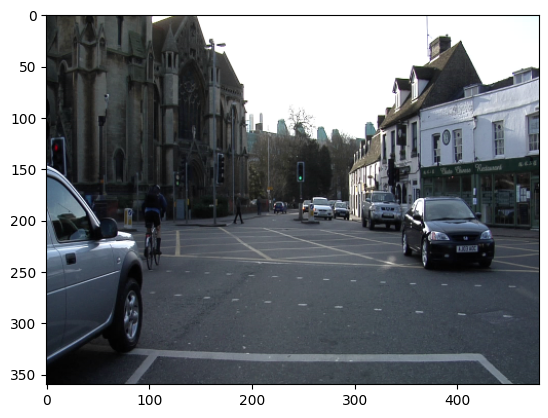

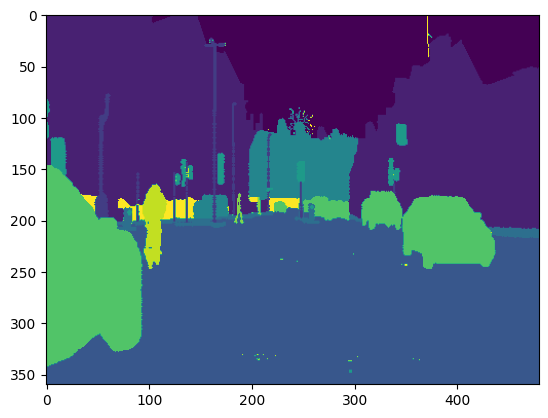

[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. 11.]
(360, 480, 3)


In [ ]:
sample = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
image, mask = sample[0]
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

print(np.unique(mask))
print(image.shape)

In [ ]:
train_dataset = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR, data_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = CityScapes(TEST_IMG_DIR, TEST_MASK_DIR, data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

## Model Architecture

## DoubleConv

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

## UNet

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # doblemconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# FCN8s

In [ ]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Engine function

## Dice coefficient metrics

In [ ]:
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
      dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

## IoU Metrics

In [ ]:
def calculate_iou_score(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_scores(ground_truths, predictions):
    num_samples = len(ground_truths)
    iou_scores = np.zeros(num_samples)
    for i in range(num_samples):
        iou_scores[i] = calculate_iou_score(ground_truths[i], predictions[i])
    return iou_scores

## Training Phase

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 28.1 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchmetrics

In [ ]:
def check_dice_score(loader, model, device):
    dice_score = 0
    dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = torch.as_tensor(y, dtype=torch.int64, device=device)
            preds = model(x)
            dice_score += dice_score_function(preds, y)

    print(f"Dice score: {dice_score/len(loader)}")
    print(f"Loss Dice score: {1 - dice_score/len(loader)}")
    model.train()

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
  #please do training step in this function
  model.train()
  loss_one_step = 0
  loop = tqdm(dataloader)
  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      # forward
      with torch.cuda.amp.autocast():
          predictions = model(data)
          loss = criterion(predictions, targets)

      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      loss_one_step += loss.item()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader)

def evaluate(model, dataloader, criterion, device):
  #please do evaluation step that calculate evaluation loss and evaluation metrics dice_score_coefficient
  model.eval()
  dice_score = 0
  dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)

  loss_one_step = 0
  loop = tqdm(dataloader)

  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      with torch.no_grad():
          with torch.cuda.amp.autocast():
              predictions = model(data)
              loss = criterion(predictions, targets)

              # Dice Score
              dice_score += dice_score_function(predictions, targets)

      loss_one_step += loss.item()

      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader), dice_score / len(dataloader)

In [ ]:
def train(model, num_epochs=5):
  #please init everthing in here and do the training process
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, scaler, device)
    test_loss, dice_score = evaluate(model, test_dataloader, criterion, device)
    print("\nDice Score : ", dice_score.cpu().numpy())
    print("Loss Dice Score : ", 1 - dice_score.cpu().numpy())
    print()

In [ ]:
model = FCN8s(3, 12)
train(model, num_epochs=50)

[INFO]: Epoch 1 of 50


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=3.5]



Dice Score :  0.38877633
Loss Dice Score :  0.6112236678600311

[INFO]: Epoch 2 of 50


100%|██████████| 7/7 [00:02<00:00,  3.49it/s, loss=0.981]



Dice Score :  0.70637316
Loss Dice Score :  0.2936268448829651

[INFO]: Epoch 3 of 50


100%|██████████| 7/7 [00:01<00:00,  4.72it/s, loss=0.978]



Dice Score :  0.70448387
Loss Dice Score :  0.29551613330841064

[INFO]: Epoch 4 of 50


100%|██████████| 7/7 [00:01<00:00,  4.77it/s, loss=0.664]



Dice Score :  0.7741188
Loss Dice Score :  0.22588121891021729

[INFO]: Epoch 5 of 50


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.605]



Dice Score :  0.8078974
Loss Dice Score :  0.1921026110649109

[INFO]: Epoch 6 of 50


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, loss=0.563]



Dice Score :  0.8093199
Loss Dice Score :  0.19068008661270142

[INFO]: Epoch 7 of 50


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=0.557]



Dice Score :  0.82173336
Loss Dice Score :  0.17826664447784424

[INFO]: Epoch 8 of 50


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=0.476]



Dice Score :  0.84410304
Loss Dice Score :  0.15589696168899536

[INFO]: Epoch 9 of 50


100%|██████████| 7/7 [00:02<00:00,  3.41it/s, loss=0.569]



Dice Score :  0.824087
Loss Dice Score :  0.1759129762649536

[INFO]: Epoch 10 of 50


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.457]



Dice Score :  0.8414333
Loss Dice Score :  0.15856671333312988

[INFO]: Epoch 11 of 50


100%|██████████| 7/7 [00:02<00:00,  2.45it/s, loss=0.558]



Dice Score :  0.81500447
Loss Dice Score :  0.18499553203582764

[INFO]: Epoch 12 of 50


100%|██████████| 7/7 [00:01<00:00,  4.76it/s, loss=0.482]



Dice Score :  0.8317284
Loss Dice Score :  0.16827160120010376

[INFO]: Epoch 13 of 50


100%|██████████| 7/7 [00:02<00:00,  2.82it/s, loss=0.44]



Dice Score :  0.85447615
Loss Dice Score :  0.14552384614944458

[INFO]: Epoch 14 of 50


100%|██████████| 7/7 [00:01<00:00,  4.73it/s, loss=0.471]



Dice Score :  0.8428215
Loss Dice Score :  0.15717852115631104

[INFO]: Epoch 15 of 50


100%|██████████| 7/7 [00:02<00:00,  3.33it/s, loss=0.465]



Dice Score :  0.8388555
Loss Dice Score :  0.16114449501037598

[INFO]: Epoch 16 of 50


100%|██████████| 7/7 [00:01<00:00,  4.70it/s, loss=0.333]



Dice Score :  0.8813262
Loss Dice Score :  0.11867380142211914

[INFO]: Epoch 17 of 50


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.61]



Dice Score :  0.8043765
Loss Dice Score :  0.195623517036438

[INFO]: Epoch 18 of 50


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=0.352]



Dice Score :  0.8836215
Loss Dice Score :  0.11637848615646362

[INFO]: Epoch 19 of 50


100%|██████████| 7/7 [00:01<00:00,  4.68it/s, loss=0.327]



Dice Score :  0.89081764
Loss Dice Score :  0.10918235778808594

[INFO]: Epoch 20 of 50


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.357]



Dice Score :  0.88179594
Loss Dice Score :  0.11820405721664429

[INFO]: Epoch 21 of 50


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=0.332]



Dice Score :  0.88563365
Loss Dice Score :  0.11436635255813599

[INFO]: Epoch 22 of 50


100%|██████████| 7/7 [00:02<00:00,  2.79it/s, loss=0.365]



Dice Score :  0.8812702
Loss Dice Score :  0.11872982978820801

[INFO]: Epoch 23 of 50


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=0.342]



Dice Score :  0.88780546
Loss Dice Score :  0.11219453811645508

[INFO]: Epoch 24 of 50


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=0.327]



Dice Score :  0.88910556
Loss Dice Score :  0.11089444160461426

[INFO]: Epoch 25 of 50


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=0.305]



Dice Score :  0.89852244
Loss Dice Score :  0.10147756338119507

[INFO]: Epoch 26 of 50


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=0.304]



Dice Score :  0.88461006
Loss Dice Score :  0.11538994312286377

[INFO]: Epoch 27 of 50


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=0.303]



Dice Score :  0.8980457
Loss Dice Score :  0.10195428133010864

[INFO]: Epoch 28 of 50


100%|██████████| 7/7 [00:01<00:00,  4.65it/s, loss=0.372]



Dice Score :  0.8690462
Loss Dice Score :  0.13095378875732422

[INFO]: Epoch 29 of 50


100%|██████████| 7/7 [00:02<00:00,  2.58it/s, loss=0.312]



Dice Score :  0.8961039
Loss Dice Score :  0.10389608144760132

[INFO]: Epoch 30 of 50


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=0.334]



Dice Score :  0.88315356
Loss Dice Score :  0.11684644222259521

[INFO]: Epoch 31 of 50


100%|██████████| 7/7 [00:02<00:00,  2.86it/s, loss=0.316]



Dice Score :  0.89003706
Loss Dice Score :  0.10996294021606445

[INFO]: Epoch 32 of 50


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.332]



Dice Score :  0.8802503
Loss Dice Score :  0.11974972486495972

[INFO]: Epoch 33 of 50


100%|██████████| 7/7 [00:02<00:00,  3.25it/s, loss=0.296]



Dice Score :  0.8963039
Loss Dice Score :  0.10369610786437988

[INFO]: Epoch 34 of 50


100%|██████████| 7/7 [00:01<00:00,  4.63it/s, loss=0.282]



Dice Score :  0.9011954
Loss Dice Score :  0.09880459308624268

[INFO]: Epoch 35 of 50


100%|██████████| 7/7 [00:01<00:00,  4.72it/s, loss=0.266]



Dice Score :  0.9045349
Loss Dice Score :  0.09546512365341187

[INFO]: Epoch 36 of 50


100%|██████████| 7/7 [00:01<00:00,  4.67it/s, loss=0.28]



Dice Score :  0.90366936
Loss Dice Score :  0.09633064270019531

[INFO]: Epoch 37 of 50


100%|██████████| 7/7 [00:01<00:00,  4.76it/s, loss=0.316]



Dice Score :  0.89142036
Loss Dice Score :  0.10857963562011719

[INFO]: Epoch 38 of 50


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=0.275]



Dice Score :  0.902638
Loss Dice Score :  0.0973619818687439

[INFO]: Epoch 39 of 50


100%|██████████| 7/7 [00:01<00:00,  4.73it/s, loss=0.293]



Dice Score :  0.89680415
Loss Dice Score :  0.10319584608078003

[INFO]: Epoch 40 of 50


100%|██████████| 7/7 [00:02<00:00,  3.01it/s, loss=0.305]



Dice Score :  0.8978696
Loss Dice Score :  0.10213041305541992

[INFO]: Epoch 41 of 50


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=0.286]



Dice Score :  0.8968412
Loss Dice Score :  0.10315877199172974

[INFO]: Epoch 42 of 50


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=0.276]



Dice Score :  0.907662
Loss Dice Score :  0.09233802556991577

[INFO]: Epoch 43 of 50


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.281]



Dice Score :  0.9012877
Loss Dice Score :  0.09871232509613037

[INFO]: Epoch 44 of 50


100%|██████████| 7/7 [00:01<00:00,  3.57it/s, loss=0.317]



Dice Score :  0.89911765
Loss Dice Score :  0.10088235139846802

[INFO]: Epoch 45 of 50


100%|██████████| 7/7 [00:01<00:00,  4.63it/s, loss=0.294]



Dice Score :  0.90227723
Loss Dice Score :  0.09772276878356934

[INFO]: Epoch 46 of 50


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.305]



Dice Score :  0.9065066
Loss Dice Score :  0.09349340200424194

[INFO]: Epoch 47 of 50


100%|██████████| 7/7 [00:02<00:00,  3.15it/s, loss=0.281]



Dice Score :  0.9026734
Loss Dice Score :  0.09732657670974731

[INFO]: Epoch 48 of 50


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=0.3]



Dice Score :  0.9032005
Loss Dice Score :  0.09679949283599854

[INFO]: Epoch 49 of 50


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=0.307]



Dice Score :  0.9061773
Loss Dice Score :  0.09382271766662598

[INFO]: Epoch 50 of 50


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=0.307]


Dice Score :  0.9027736
Loss Dice Score :  0.09722638130187988



In [ ]:
# cuma test2 saja, hasilnya sama dgn epoch terakhir di training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
check_dice_score(test_dataloader, model, device)

Dice score: 0.9027791619300842
Loss Dice score: 0.09722083806991577


# Test Inference

In [ ]:
def inference(tensor):
  model.eval()
  with torch.no_grad():
    tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
    result = model(tensor)
    softmax = nn.Softmax(dim=1)
    result = torch.argmax(softmax(result),axis=1).to('cpu')

  return result

def img_to_numpy(tensor):
  tensor = torch.squeeze(tensor)
  tensor = tensor.cpu().detach().numpy()
  return tensor

def inverse_transform(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img_to_numpy(img).transpose((1,2,0))
  img = (img * std+mean)
  img = np.clip(img,0,1)
  return img

def plot_inference(idx, dataset):
  fig = plt.figure(figsize=(18, 18))
  img, targets = dataset[idx]
  result = inference(img)

  fig.add_subplot(1, 3, 1)
  inv_img = inverse_transform(img)
  plt.imshow(inv_img)
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(1, 3, 2)
  plt.imshow(img_to_numpy(targets))
  plt.axis('off')
  plt.title("Target")

  fig.add_subplot(1, 3, 3)
  plt.imshow(img_to_numpy(result))
  plt.axis('off')
  plt.title("Prediction")

  plt.show()

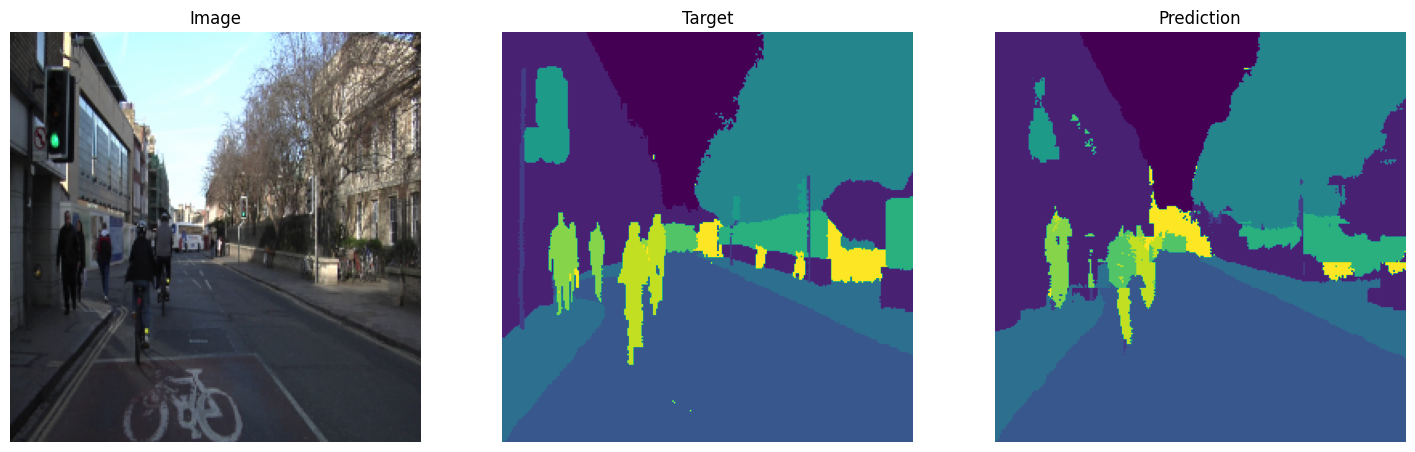

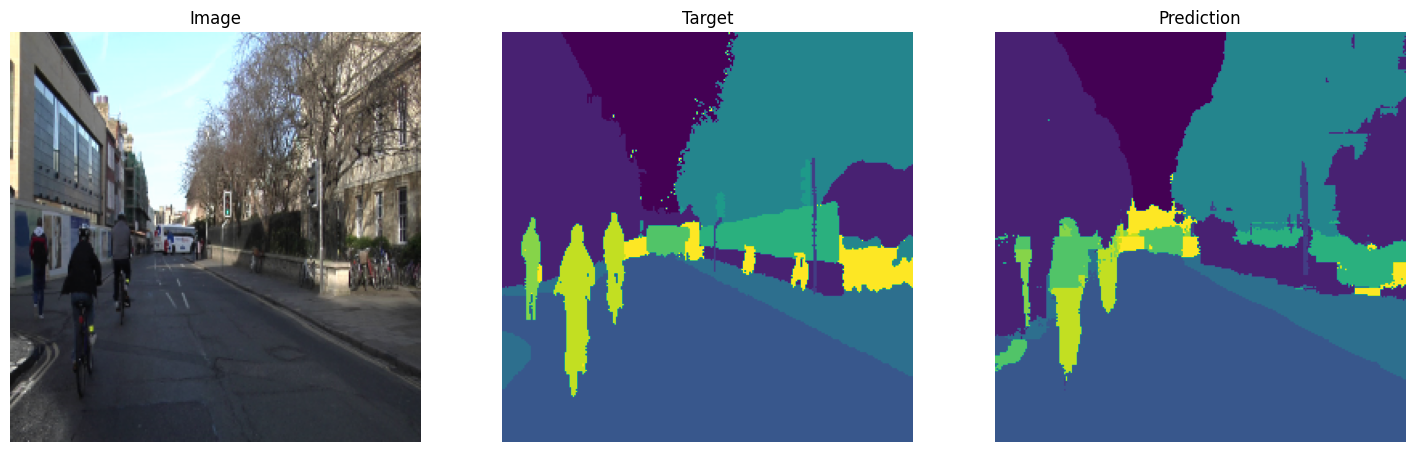

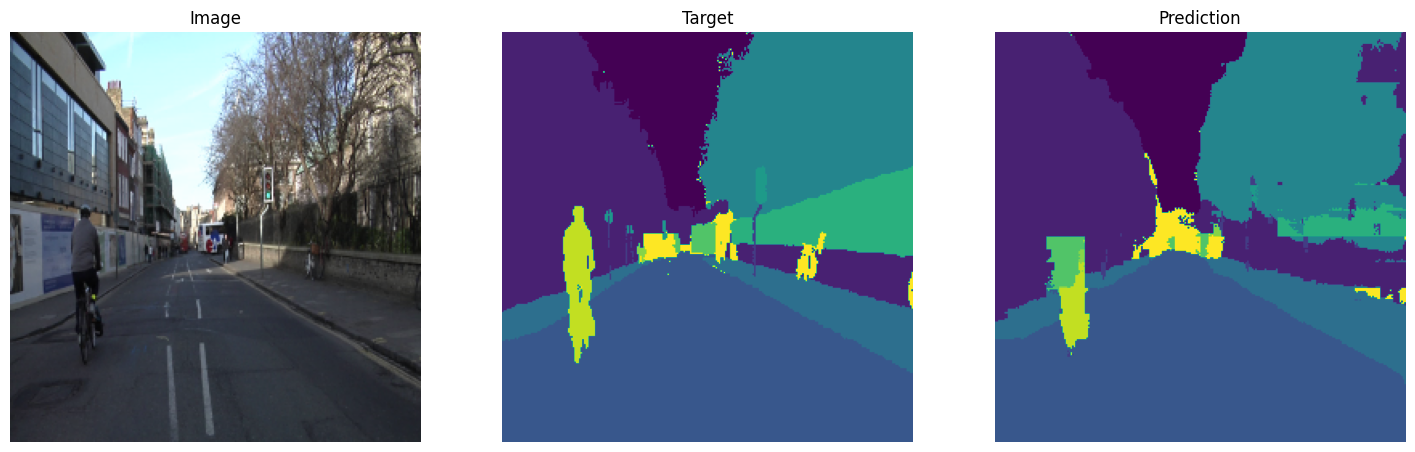

In [ ]:
get_img = 3 #inference 3 img

for idx in range(get_img):
  plot_inference(idx, test_dataset)